# Emulating cosmic shear covariances

Cosmic shear is the correlation of shapes of galaxies separated by some distance on the sky. The correlation of galaxies aligned with each other is designated by $\xi_+$. In this notebook, we will build an emulator for $\xi_+$ from a set of 25 covariances computed by Tim Eifler in a 6 dimensional parameter space (cosmology galaxy bias).

In [1]:
import numpy as np
from scipy import stats
import covariance_emulator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rc("font", size=14, family="serif")
#plt.rc("text", usetex=True)

In [3]:
#Read in the domain locations, or locations in parameter space
parameters = np.loadtxt("cosmo_parameters.txt")[:, :6] #Remove parameters that are irrelevent here
print(parameters.shape)

(25, 6)


In [4]:
#Load in the covariances
#covs = np.load("tomo0_sub_covs.npy")
covs = np.load("gaussian_tomo_sub_covs.npy")
#covs = np.load("gaussian_full_covs.npy")
#Take only a subset
covs = covs[:, 0:200, 0:200]
print(covs.shape)

(25, 200, 200)


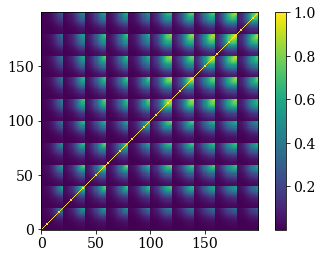

In [5]:
#View the correlation matrix of the first
def corr_from_cov(cov):
    D = np.diag(np.sqrt(cov.diagonal()))
    Di = np.linalg.inv(D)
    return np.dot(Di, np.dot(cov, Di))

def view_corr(cov, lncov=False):
    R = corr_from_cov(cov)
    fig, ax = plt.subplots()
    if lncov:
        R = np.log(np.fabs(cov))
    im = ax.imshow(R, interpolation="nearest", origin="lower")
    plt.colorbar(im)
    return

view_corr(covs[0])

In [6]:
#Split off the last covariance matrix
test_cov = covs[-1]
test_parameters = parameters[-1]
covs = covs[:-1]
parameters = parameters[:-1]

In [7]:
#Create an emulator
Emu = covariance_emulator.CovEmu(parameters, covs, NPC_D=6, NPC_L=6)
#Predict
print(test_parameters.shape)
Cpredicted = Emu.predict(test_parameters)

(6,)


In [8]:
Lps = Emu.Lprimes
print(Lps[0].shape)
print(Lps[0][:10])

(19900,)
[0.00080334 0.00114662 0.00164353 0.00236439 0.00341504 0.00495494
 0.00722283 0.01050574 0.01527175 0.02214258]


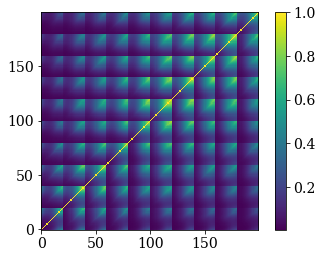

In [9]:
#View the test covariance matrix
view_corr(Cpredicted)

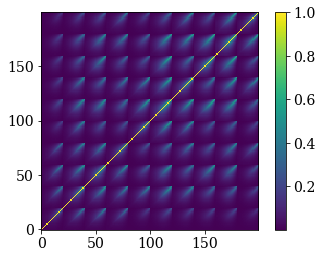

In [10]:
#View the test covariance matrix
view_corr(test_cov)

In [11]:
#Define a function to pull out just the off-diagonals and compute the fractional differences
def get_fracdiff_in_offdiag(C1, C2, ndim):
    D = C1 - C2
    out = np.zeros(int(ndim*(ndim-1)/2))
    k = 0
    for i in range(1,ndim):
        for j in range(0,i):
            out[k] = D[i,j]/C1[i,j]
            k+=1
    return out

In [12]:
diff = test_cov - Cpredicted
print("Mean fractional differences in off-diagonals:")
fracdiffs = get_fracdiff_in_offdiag(test_cov, Cpredicted, len(test_cov))
print(np.mean(fracdiffs), np.min(fracdiffs), np.max(fracdiffs))
print("Fractional differences in diagonals:")
#print(diff.diagonal()/test_cov.diagonal())
print(np.mean(diff.diagonal()/test_cov.diagonal()))

Mean fractional differences in off-diagonals:
(-9.717823617632634, -927.6479598326551, -0.23558674433875354)
Fractional differences in diagonals:
-0.6512897508700866


It appears that the diagonals are predicted to about 4% accuracy, and the off diagonals are less accurate, but very small.

## Finding an optimal emulator

The covariance emulator built above was done with the default configuration with a few principle components, but it actually has a few knobs to turn. We can control not only the number of principle components for D and L (`NPC_D, NPC_L`), but we can also create and pass in `george` kernels for both `D` and `L`. In the next cell, we will look over all reasonable options, and figure out which emulator setup is the best. As a summary statistic, we will use the total fractional difference
$$
S = \sum_{i,j\geq i} \left|\frac{C_{ij} - C_{ij}^{\rm emu}}{C_{ij}}\right|\,.
$$

In [13]:
#The summary statistics function
def total_frac_diff(C1, C2):
    S = 0
    for i in range(len(C1)):
        for j in range(i, len(C1)):
            S += np.fabs((C1[i,j] - C2[i,j])/C1[i,j])
    return S

In [14]:
import george.kernels as kernels
kerns = [kernels.ExpSquaredKernel, kernels.Matern52Kernel, 
         kernels.Matern32Kernel]
names = ["Exp2", "Mat52", "Mat32"]
Npars = len(parameters[0])
metric_guess = np.std(parameters, 0)
best_S = 1e99
best_name = ""
#For now, let's just use NPC_D = NPC_L = 6
for nameD, kd in zip(names, kerns):
    kernel_D = 1.*kd(metric=metric_guess, ndim=Npars)
    for nameL, kl in zip(names, kerns):
        kernel_L = 1.*kl(metric=metric_guess, ndim=Npars)
        Emu = covariance_emulator.CovEmu(parameters, covs, NPC_D=6, NPC_L=6, 
                                         kernel_D = kernel_D, kernel_lp = kernel_L)
        try:
            Cpredicted = Emu.predict(test_parameters)
        except np.linalg.LinAlgError:
            S = 1e99
        else:
            S = total_frac_diff(test_cov, Cpredicted)
        if S < best_S:
            best_S = S
            best_name = "%s & %s"%(nameD, nameL)
        print"%s & %s: %e"%(nameD, nameL, S)
print "Best combination: %s"%best_name

Exp2 & Exp2: 1.935152e+05
Exp2 & Mat52: 3.967917e+04
Exp2 & Mat32: 1.019687e+04
Mat52 & Exp2: 1.948294e+05
Mat52 & Mat52: 4.028380e+04
Mat52 & Mat32: 1.067713e+04
Mat32 & Exp2: 1.966851e+05
Mat32 & Mat52: 4.123376e+04
Mat32 & Mat32: 1.146866e+04
Best combination: Exp2 & Mat32


Text(0.5,1,'$\\xi_+$ all')

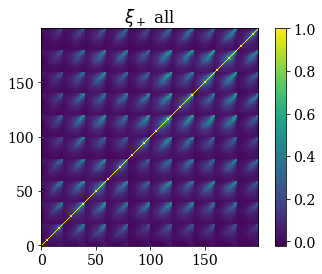

In [15]:
#Let's visualize
kernel_L = 1.*kernels.Matern32Kernel(metric=metric_guess, ndim=Npars)
Emu = covariance_emulator.CovEmu(parameters, covs, NPC_D=6, NPC_L=6, kernel_lp=kernel_L)
Cpredicted = Emu.predict(test_parameters)
view_corr(Cpredicted)
plt.title(r"$\xi_+$ all")
#plt.savefig("predicted_cov.png", dpi=300, bbox_inches="tight")

Text(0.5,1,'$\\xi_+$ all')

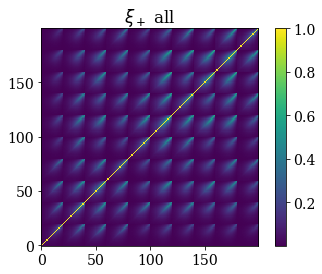

In [16]:
view_corr(test_cov)
plt.title(r"$\xi_+$ all")
#plt.savefig("true_cov.png", dpi=300, bbox_inches="tight")

Text(0,0.5,'Fractional difference')

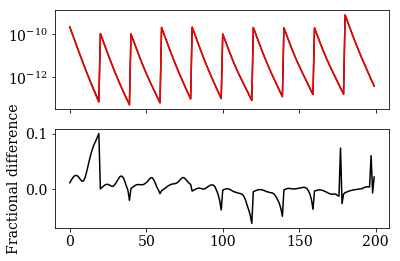

In [17]:
true_var = test_cov.diagonal()
emu_var = Cpredicted.diagonal()
frac_diff = (true_var - emu_var) / true_var

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(true_var, c='k', label='True variance')
ax[0].plot(emu_var, c='r', label='Emulated variance')
ax[1].plot(frac_diff, c='k')
ax[0].set_yscale('log')
ax[1].set_ylabel(r"Fractional difference")
#ax[1].set_ylim(-2.5, 2.5)

## Assessing the emulator performance

One of the best ways to assess the performance of the emulator is to directly compare the true covariance to the emulated covariance. In the next cell, I will draw realizations of the noise from the true covariance, and compute $\chi^2$ values of these noises compared agains the emulated covariance. Then, by checking this against the expected distribution, we can see the performance of the emulator.

In [18]:
#Define a function where we input two covariances, and get back out a list of chi2s
def get_chi2s_between_Cs(C1, C2, N_samples=10000):
    means = np.zeros(len(C1))
    chi2s = np.zeros(N_samples)
    iC2 = np.linalg.inv(C2)
    for i in range(N_samples):
        x = np.random.multivariate_normal(means, C1)
        chi2s[i] = np.dot(x, np.dot(iC2, x))
    return chi2s

dof = len(test_cov)
x = np.linspace(0, 2*dof, 1000)
chi2s = get_chi2s_between_Cs(test_cov, test_cov)

Text(0.5,1,'$C_{\\rm true}$ vs $C_{\\rm true}$')

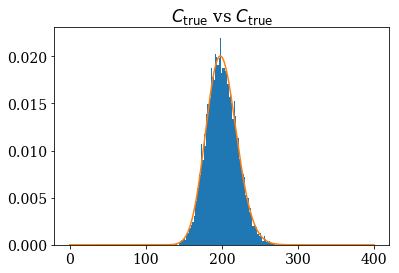

In [19]:
plt.hist(chi2s, density=True, bins=100)
plt.plot(x, stats.chi2.pdf(x, dof))
plt.title(r"$C_{\rm true}$ vs $C_{\rm true}$")

Text(0.7,0.5,'$\\chi2=d^TC^{-1}d$')

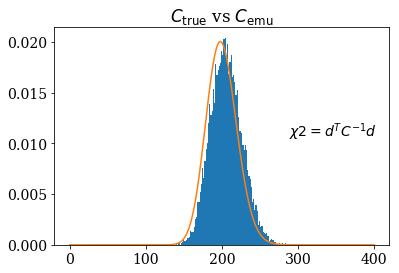

In [20]:
chi2s = get_chi2s_between_Cs(test_cov, Cpredicted, 10000)
plt.hist(chi2s, density=True, bins=100)
plt.plot(x, stats.chi2.pdf(x, dof))
plt.title(r"$C_{\rm true}$ vs $C_{\rm emu}$")
ax = plt.gca()
ax.text(0.7, 0.5, r"$\chi2=d^TC^{-1}d$", transform=ax.transAxes)

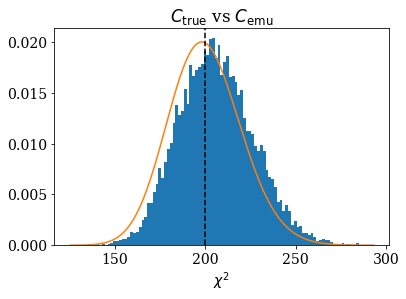

In [26]:
plt.hist(chi2s, density=True, bins=100)
x = np.linspace(min(chi2s)*0.97, 1.03*max(chi2s), 1000)
plt.plot(x, stats.chi2.pdf(x, dof))
plt.title(r"$C_{\rm true}$ vs $C_{\rm emu}$")
plt.xlabel(r"$\chi^2$")
plt.axvline(dof, color="k", ls="--")
ax = plt.gca()
#ax.text(0.7, 0.5, r"$\chi2=d^TC^{-1}d$", transform=ax.transAxes)
plt.savefig("chi2_realizations.png", dpi=300, bbox_inches="tight")